# [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem)

## [Abstract](#abstract)

The Traveling Salesman Problem (TSP) is a **classic problem in [combinatorial optimization](https://en.wikipedia.org/wiki/Combinatorial_optimization)**.

It is the problem of **finding a tour of minimum cost that visits each city exactly once**. The TSP is **NP-hard**. That is, no efficient algorithm is known that finds the optimal solution to the problem for large sets of cities.

## [Exhaustive](#exhaustive-search)
It is a **brute force** algorithm that does not use any information about the problem to find the solution.

- [Heap's Algorithm](#heaps-algorithm)
- [Steinhaus–Johnson–Trotter Algorithm](#sjt-algorithm)

## [Random](#random-search)
Is a **[stochastic optimization](https://en.wikipedia.org/wiki/Stochastic_optimization)** algorithm that does not use any information about the problem to find the solution.

## [Hill Climbing](#hill-climbing-search)
Is a **[local search](https://en.wikipedia.org/wiki/Local_search_(optimization))** algorithm that does not use any information about the problem to find the solution.

----

### Abstract

In this notebook, we're exploring various techniques to solve the [Traveling Salesman Problem (TSP)](https://en.wikipedia.org/wiki/Travelling_salesman_problem).

Our focus is on implementing **exhaustive search**, **random search**, and **hill-climbing algorithms** to tackle this problem. Additionally, **we'll visualize the results of each iteration**, **analyze their performance**, and **draw insightful conclusions**.

By delving into these algorithms and their outcomes, we aim to enhance our understanding of optimization techniques and their practical applications.

In [1]:
import itertools  # for permutations

import numpy as np  # for arrays
import pandas as pd  # for dataframes
import seaborn as sns  # for plotting
import matplotlib.pyplot as plt  # for plotting

# constants for the genetic algorithm
CITIES = 30  # number of cities
GENERATIONS = 100  # number of generations to run
MUTATION_RATE = 0.01  # mutation rate (0.01 = 1%) 1/100

In these part I've define some functions to help us to manage all the algorithms and to visualize the results.

In [2]:
def generate_cities(cities: int) -> np.ndarray:
    """Generate cities with random x and y coordinates."""
    return np.random.rand(cities, 2)

def get_distance_between_cities(city1: np.ndarray, city2: np.ndarray) -> float:
    """Get distance between two cities."""
    return np.sqrt((city1[0] - city2[0]) ** 2 + (city1[1] - city2[1]) ** 2)

def print_distances(cities: np.ndarray, solution: np.ndarray) -> None:
    """Print distances between cities according to the order in the solution."""
    distances = [get_distance_between_cities(cities[solution[i]], cities[solution[i + 1]]) for i in range(len(cities) - 1)]
    print(f"Solution:  {solution}\nDistance: {sum(distances)}")  # print solution and total distance
    [print(f"{solution[i-1]} -> {solution[i]}: {distances[i]}") for i in range(len(cities) - 1)]  # print distances between cities

def plot_solution(title: str, cities: np.ndarray, solution: np.ndarray) -> None:
    """Plot solution."""
    plt.figure(figsize=(12, 12))
    [plt.plot([cities[solution[i]][0], cities[solution[i + 1]][0]], [cities[solution[i]][1], cities[solution[i + 1]][1]], c='blue') for i in range(len(cities) - 1)]
    # plt.plot([cities[solution[-1]][0], cities[solution[0]][0]], [cities[solution[-1]][1], cities[solution[0]][1]], c='blue')  # plot a line between the last and the first city
    plt.scatter(cities[:, 0], cities[:, 1], c='blue', s=100)
    plt.title(title)
    plt.show()

def get_fitness(cities: np.ndarray, solution) -> float:
    """
    Get fitness of a solution.
    In most cases, fitness is the inverse of the total distance.
    In this case we will use the total distance as fitness. This because we want to minimize the distance.    
    """
    # distances = [get_distance_between_cities(cities[solution[i]], cities[solution[i + 1]]) for i in range(CITIES - 1)]
    # return sum(distances)  # return fitness
    return sum([get_distance_between_cities(cities[solution[i]], cities[solution[i + 1]]) for i in range(len(cities) - 1)])

def plot_fitness(title: str, fitness: list) -> None:
    """Plot fitness."""
    plt.plot(fitness)
    plt.title(title)
    plt.show()

def crossover(parents: np.ndarray) -> np.ndarray:
    """Crossover parents to produce offspring."""
    return np.concatenate((parents[0][:CITIES // 2], [city for city in parents[1] if city not in parents[0][:CITIES // 2]]))

def mutate(offspring: np.ndarray) -> np.ndarray:
    """
    Mutate offspring.
    Shuffle offspring (mutation) if mutation rate is reached.
    """
    if np.random.rand() < MUTATION_RATE:  # if mutation rate is reached
        offspring = np.random.permutation(offspring)  # shuffle offspring (mutation)
    return offspring  # return offspring


[[ 1.00000000e+00  0.00000000e+00]
 [ 9.78147601e-01  2.07911691e-01]
 [ 9.13545458e-01  4.06736643e-01]
 [ 8.09016994e-01  5.87785252e-01]
 [ 6.69130606e-01  7.43144825e-01]
 [ 5.00000000e-01  8.66025404e-01]
 [ 3.09016994e-01  9.51056516e-01]
 [ 1.04528463e-01  9.94521895e-01]
 [-1.04528463e-01  9.94521895e-01]
 [-3.09016994e-01  9.51056516e-01]
 [-5.00000000e-01  8.66025404e-01]
 [-6.69130606e-01  7.43144825e-01]
 [-8.09016994e-01  5.87785252e-01]
 [-9.13545458e-01  4.06736643e-01]
 [-9.78147601e-01  2.07911691e-01]
 [-1.00000000e+00  5.66553890e-16]
 [-9.78147601e-01 -2.07911691e-01]
 [-9.13545458e-01 -4.06736643e-01]
 [-8.09016994e-01 -5.87785252e-01]
 [-6.69130606e-01 -7.43144825e-01]
 [-5.00000000e-01 -8.66025404e-01]
 [-3.09016994e-01 -9.51056516e-01]
 [-1.04528463e-01 -9.94521895e-01]
 [ 1.04528463e-01 -9.94521895e-01]
 [ 3.09016994e-01 -9.51056516e-01]
 [ 5.00000000e-01 -8.66025404e-01]
 [ 6.69130606e-01 -7.43144825e-01]
 [ 8.09016994e-01 -5.87785252e-01]
 [ 9.13545458e-01 -4

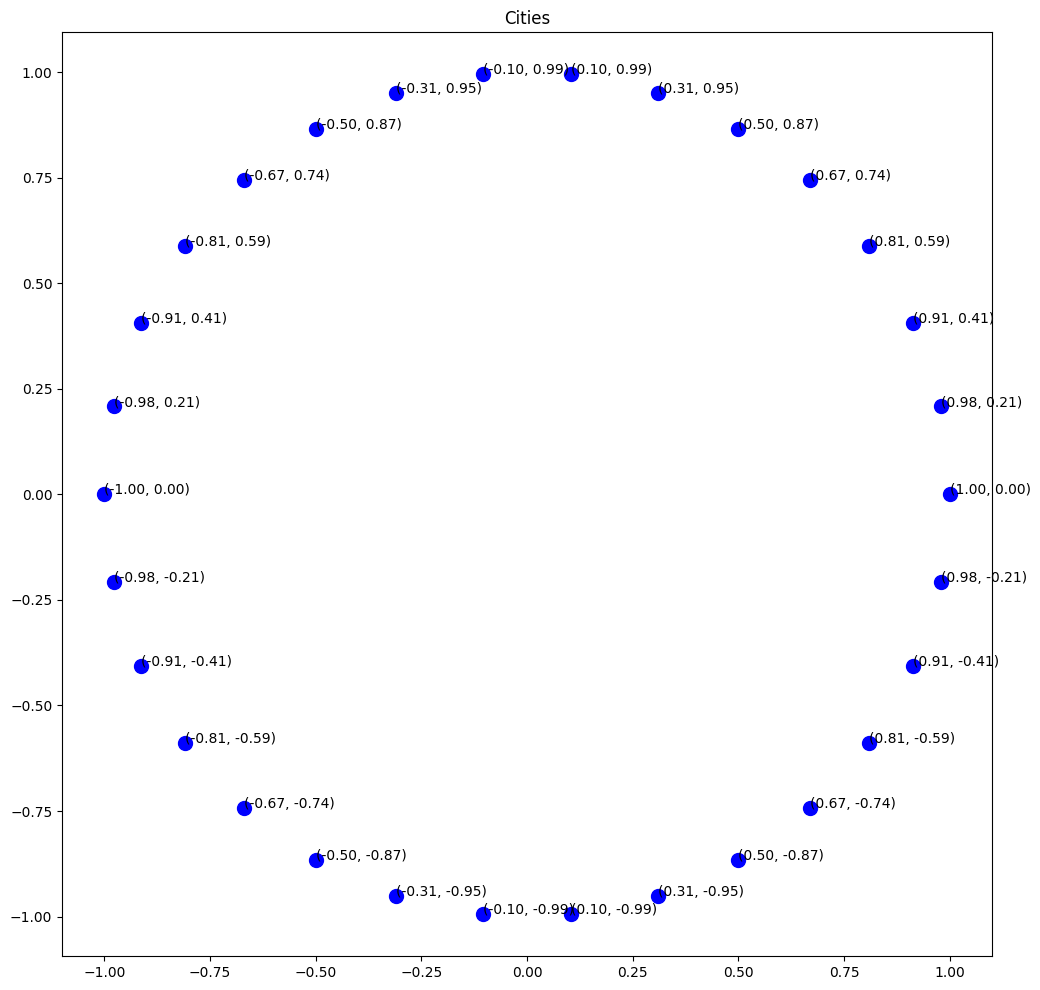

In [3]:
# cities = generate_cities(CITIES)  # generate cities
cities = np.array([[np.cos(2 * np.pi * i / CITIES), np.sin(2 * np.pi * i / CITIES)] for i in range(CITIES)])
print(cities)

# draw the circle
plt.figure(figsize=(12, 12))
# plt.plot(np.cos(2 * np.pi * np.linspace(0, 1, 100)), np.sin(2 * np.pi * np.linspace(0, 1, 100)), c='gray')  # draw the circle
plt.scatter(cities[:, 0], cities[:, 1], c='blue', s=100)  # draw the cities
[plt.annotate(f"({city[0]:.2f}, {city[1]:.2f})", (city[0], city[1]), fontsize=10) for _, city in enumerate(cities)]  # add the coordinates to the cities
plt.title("Cities")
plt.show()

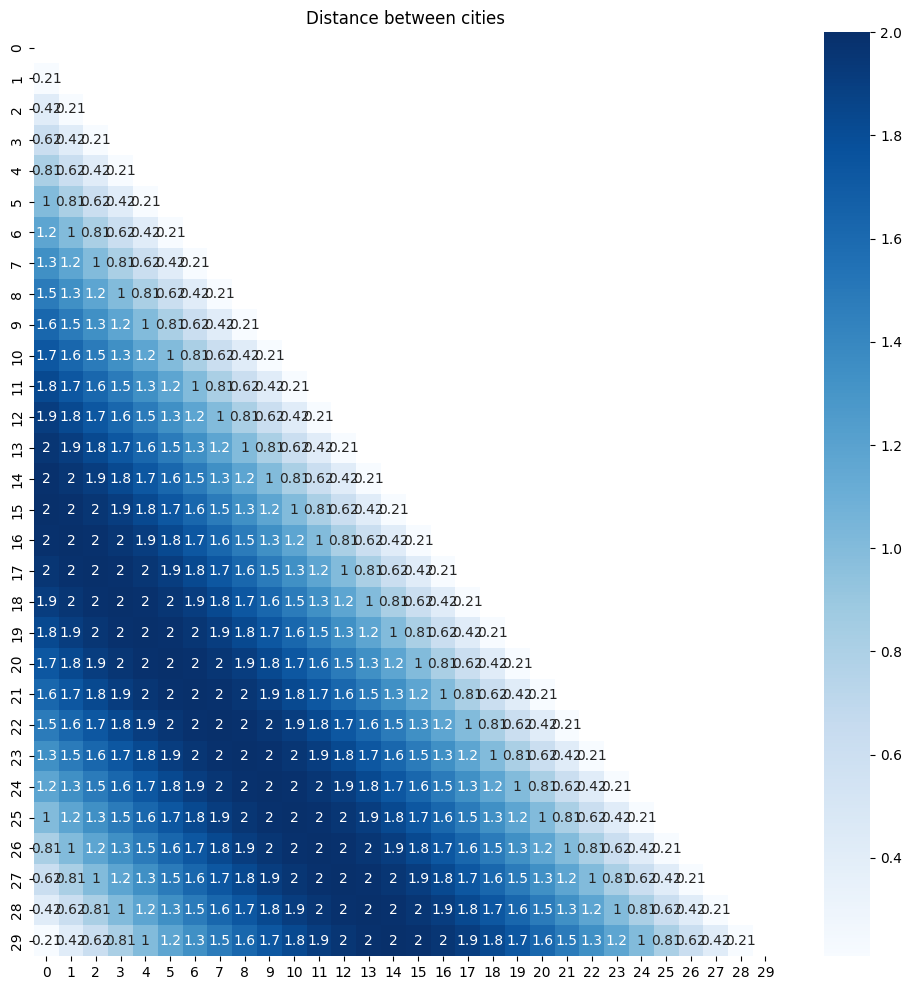

In [4]:
distances: np.ndarray = np.array([[get_distance_between_cities(cities[i], cities[j]) for j in range(CITIES)] for i in range(CITIES)])

# plot the distance between cities (using heatmap)
plt.figure(figsize=(12, 12))
mask = np.zeros_like(distances)  # create a mask
mask[np.triu_indices_from(mask)] = True  # apply the mask
sns.heatmap(distances, annot=True, mask=mask, cmap='Blues')  # plot heatmap
plt.title('Distance between cities')
plt.show()

### [Exhaustive Search](https://en.wikipedia.org/wiki/Exhaustive_search)

We implement a program that generates all possible solutions for the TSP using two algorithms, namely the **Heap algorithm** and the **Steinhaus–Johnson–Trotter algorithm**. By examining the complete solution space, we aim to evaluate the computational feasibility of exhaustively solving TSP for a given number of cities.

- Time Complexity: $O(n!)$
- Space Complexity: $O(n)$

In [5]:
def exhaustive_search(cities: np.ndarray) -> tuple[np.ndarray, list[float]]:
    """Exhaustive search algorithm."""
    best_solution: np.ndarray = np.arange(CITIES)
    best_fitness = get_fitness(cities, best_solution)
    all_fitnesses = []  # list that will contain all fitnesses (for plotting)

    for solution in itertools.permutations(np.arange(CITIES)):
        fitness = get_fitness(cities, solution)
        if fitness < best_fitness:  # if new best solution is found
            all_fitnesses.append(fitness)
            print(f"New best solution found: {solution} with fitness \033[92m{fitness}\033[0m")
            best_fitness = fitness  # update best fitness
            best_solution = solution  # type: ignore # update best solution
    return (best_solution, all_fitnesses)  # return best solution

#! this next 4 lines are commented out because they take a long time to run...
# exhaustive_solution = exhaustive_search(cities)  # run exhaustive search
# plot_fitness("Exhaustive Fitness", exhaustive_solution[1])  # plot fitness

In [6]:
# print_distances(cities, exhaustive_solution[0])  # print distances
# plot_solution("Exhaustive Search (Best Solution)", cities, exhaustive_solution[0])  # plot solution

#### [Heap's Algorithm](https://en.wikipedia.org/wiki/Heap%27s_algorithm)

The Heap's Algorithm constructs all possible permutations of $n$ objects. It is a **[recursive](https://en.wikipedia.org/wiki/Recursion_(computer_science))** algorithm that generates each permutation from the previous one by choosing two elements to interchange.

The algorithm generates each permutation from the previous one by choosing two elements to interchange. The number of permutations of $n$ objects is $n!$.

The algorithm is named after [B. R. Heap](https://en.wikipedia.org/wiki/B._R._Heap), who published it in 1963, but it was first proposed by [Johnson](https://en.wikipedia.org/wiki/Johnson%27s_algorithm) in 1962.

Fitness of permutation 0: 6.062650869523903
Fitness of permutation 1: 5.853593942988597
Fitness of permutation 2: 6.062650869523903
Fitness of permutation 3: 5.853593942988597
Fitness of permutation 4: 6.062650869523903
Fitness of permutation 5: 5.853593942988597
Fitness of permutation 6: 6.269417324624115
Fitness of permutation 7: 5.853593942988597
Fitness of permutation 8: 6.062650869523903
Fitness of permutation 9: 5.853593942988597
Fitness of permutation 10: 6.062650869523903
Fitness of permutation 11: 5.853593942988597
Fitness of permutation 12: 6.062650869523903
Fitness of permutation 13: 5.853593942988597
Fitness of permutation 14: 6.062650869523903
Fitness of permutation 15: 5.853593942988597
Fitness of permutation 16: 6.062650869523903
Fitness of permutation 17: 5.853593942988597
Fitness of permutation 18: 5.64453701645329
Fitness of permutation 19: 5.435480089917982
Fitness of permutation 20: 5.435480089917982
Fitness of permutation 21: 5.435480089917982
Fitness of permutatio

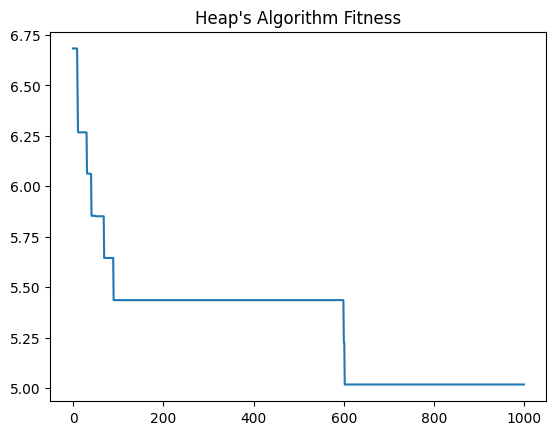

In [74]:
def heaps_algorithm(cities: np.ndarray, size: int, generations: int = 1000) -> tuple[np.ndarray, list[float]]:
    permutations = []  # List to store permutations
    fitnesses = []  # List to store fitness values

    # Auxiliary function to generate all permutations of a list
    def generate_permutations(cities: np.ndarray, n: int) -> None:
        nonlocal permutations, fitnesses  # nonlocal variables (to be able to modify them)

        if n != 1:  # If size is not 1, then generate all permutations of size n-1
            for i in range(n):  # One by one move all characters from the first to the last
                generate_permutations(cities, n - 1)  # Call itself recursively to generate permutations
                if n % 2 == 0:  # If n is even, swap the i-th and the last element
                    cities[i], cities[n - 1] = cities[n - 1], cities[i]
                else:  # If n is odd, swap the first and the last element
                    cities[0], cities[n - 1] = cities[n - 1], cities[0]
                if len(permutations) >= generations:  # Check if the maximum number of generations is reached
                    return
        else:  # If size is 1, then append the obtained permutation
            permutations.append(cities.copy())  # If size is 1, then append the obtained permutation

    generate_permutations(cities.copy(), size)  # Generate all permutations of cities
    for i in range(len(permutations)):  # Calculate the fitness of each permutation
        fitnesses.append(sum([get_distance_between_cities(permutations[i][j], permutations[i][j + 1]) for j in range(len(permutations[i]) - 1)]))
        print(f"Fitness of permutation {i}: {fitnesses[i]}")

    return permutations[fitnesses.index(min(fitnesses))], fitnesses  # Return the best solution and all fitnesses

heaps_solution = heaps_algorithm(cities.copy(), len(np.arange(CITIES)))
plot_fitness("Heap's Algorithm Fitness", sorted(heaps_solution[1], reverse=True))  # plot fitness

[[ 5.00000000e-01  8.66025404e-01]
 [ 5.00000000e-01  8.66025404e-01]
 [ 5.00000000e-01  8.66025404e-01]
 [ 5.00000000e-01  8.66025404e-01]
 [ 5.00000000e-01  8.66025404e-01]
 [ 5.00000000e-01  8.66025404e-01]
 [ 3.09016994e-01  9.51056516e-01]
 [ 1.04528463e-01  9.94521895e-01]
 [-1.04528463e-01  9.94521895e-01]
 [-3.09016994e-01  9.51056516e-01]
 [-5.00000000e-01  8.66025404e-01]
 [-6.69130606e-01  7.43144825e-01]
 [-8.09016994e-01  5.87785252e-01]
 [-9.13545458e-01  4.06736643e-01]
 [-9.78147601e-01  2.07911691e-01]
 [-1.00000000e+00  5.66553890e-16]
 [-9.78147601e-01 -2.07911691e-01]
 [-9.13545458e-01 -4.06736643e-01]
 [-8.09016994e-01 -5.87785252e-01]
 [-6.69130606e-01 -7.43144825e-01]
 [-5.00000000e-01 -8.66025404e-01]
 [-3.09016994e-01 -9.51056516e-01]
 [-1.04528463e-01 -9.94521895e-01]
 [ 1.04528463e-01 -9.94521895e-01]
 [ 3.09016994e-01 -9.51056516e-01]
 [ 5.00000000e-01 -8.66025404e-01]
 [ 6.69130606e-01 -7.43144825e-01]
 [ 8.09016994e-01 -5.87785252e-01]
 [ 9.13545458e-01 -4

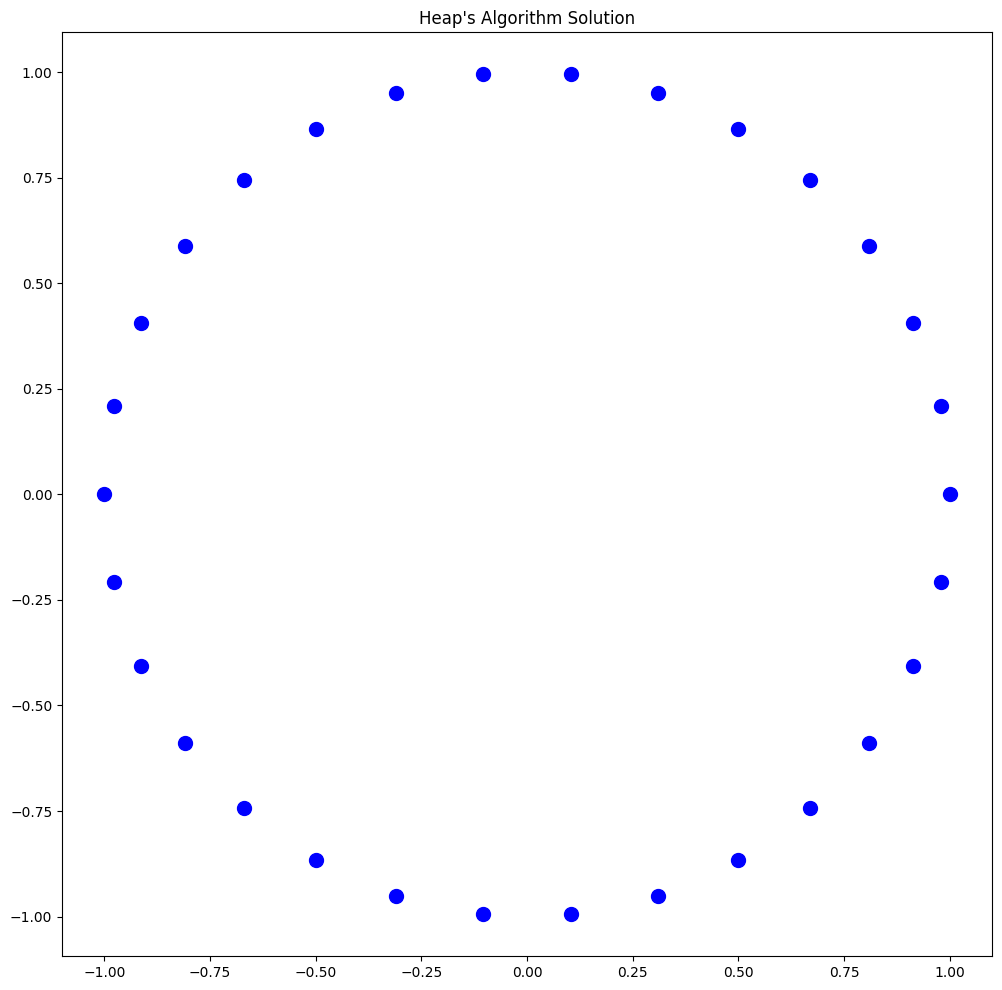

In [75]:
# print_distances(cities, heap_solution)
plt.figure(figsize=(12, 12))
plt.scatter(cities[:, 0], cities[:, 1], c='blue', s=100)  # draw the cities

print(heaps_solution[0])

plt.title("Heap's Algorithm Solution")
plt.show()

#### [SJT Algorithm](https://en.wikipedia.org/wiki/Steinhaus%E2%80%93Johnson%E2%80%93Trotter_algorithm)

The Steinhaus-Johnson-Trotter (SJT) algorithm is a **[recursive](https://en.wikipedia.org/wiki/Recursion_(computer_science))** algorithm that generates each permutation from the previous one by choosing two elements to interchange.

The algorithm generates each permutation from the previous one by choosing two elements to interchange. The number of permutations of $n$ objects is $n!$.

The algorithm is named after [Hugo Steinhaus](https://en.wikipedia.org/wiki/Hugo_Steinhaus), [Selmer M. Johnson](https://en.wikipedia.org/wiki/Selmer_M._Johnson), and [Hale F. Trotter](https://en.wikipedia.org/wiki/Hale_F._Trotter), who published it in 1963, but it was first proposed by [Johnson](https://en.wikipedia.org/wiki/Johnson%27s_algorithm) in 1962.

  0: [30 29 28 27 26 25 24  9 14 23  8 13 10  5  2  1 11 16  4 20  3 22 18 19
  6 15  7 21 17 12] -> 31.6098
  1: [ 9 14 29  8 13 10  5  2 27  1 11 30 26 16  4 20  3 22 24 18 19  6 25 23
 15 28  7 21 17 12] -> 38.3096
  2: [ 9 14 29  8 13 10  5  2 27  1 30 11 26 16  4 20  3 22 24 18 19  6 25 23
 15 28  7 21 17 12] -> 37.9731
  3: [ 9 14 29  8 13 10  5  2 27 30  1 11 26 16  4 20  3 22 24 18 19  6 25 23
 15 28  7 21 17 12] -> 37.6826
  4: [ 9 14 29  8 13 10  5  2 30 27  1 11 26 16  4 20  3 22 24 18 19  6 25 23
 15 28  7 21 17 12] -> 37.7029
  5: [ 9 14 29  8 13 10  5 30  2 27  1 11 26 16  4 20  3 22 24 18 19  6 25 23
 15 28  7 21 17 12] -> 38.4668
  6: [ 9 14 29  8 13 10 30  5  2 27  1 11 26 16  4 20  3 22 24 18 19  6 25 23
 15 28  7 21 17 12] -> 39.4011
  7: [ 9 14 29  8 13 30 10  5  2 27  1 11 26 16  4 20  3 22 24 18 19  6 25 23
 15 28  7 21 17 12] -> 40.7393
  8: [ 9 14 29  8 30 13 10  5  2 27  1 11 26 16  4 20  3 22 24 18 19  6 25 23
 15 28  7 21 17 12] -> 40.1116
  9: [ 9 14 29 30  

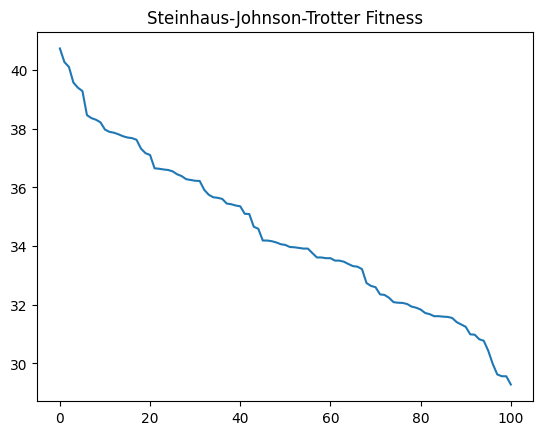

In [22]:
LEFT_TO_RIGHT = True  # LEFT TO RIGHT direction
RIGHT_TO_LEFT = False  # RIGHT TO LEFT direction

factorial = lambda n: 1 if n == 0 else n * factorial(n - 1)  # factorial function

def _get_mobile(a: list[int], dir: list[bool], n: int) -> int:
	"""Get Mobile Integer from the given array a[] and direction dir[] which shows whether dir[i] is LEFT TO RIGHT or RIGHT TO LEFT."""
	mobile_prev: int = 0  # previous mobile integer in the array
	mobile: int = 0  # mobile integer
	for i in range(n):  # find the largest mobile integer
		if dir[a[i] - 1] == RIGHT_TO_LEFT and i != 0:  # direction 0 represents RIGHT TO LEFT.
			if a[i] > a[i - 1] and a[i] > mobile_prev:  
				mobile = a[i]
				mobile_prev = mobile
		if dir[a[i] - 1] == LEFT_TO_RIGHT and i != n - 1:  # direction 1 represents LEFT TO RIGHT.
			if a[i] > a[i + 1] and a[i] > mobile_prev:
				mobile = a[i]
				mobile_prev = mobile
	if mobile == 0 and mobile_prev == 0:  # if no mobile integer is found
		return 0  # return 0 (i.e. no largest mobile integer)
	else: return mobile  # return found mobile integer


fitnesses = []  # list to store the fitness values of the permutations
permutations = []  # List to store permutations

def _get_permutation(a: list[int], dir: list[bool], n: int):
	"""
	To generate the next permutation using the given permutation
	
	### Parameters:
	- `a`: list of integers
	- `dir`: list of boolean values
	- `n`: size of list `a`
	"""
	mobile = _get_mobile(a, dir, n)
	pos: int = [i + 1 for i in range(n) if a[i] == mobile][0]

	# swapping the elements according to the direction i.e. dir[]
	if dir[a[pos - 1] - 1] == RIGHT_TO_LEFT: a[pos - 1], a[pos - 2] = a[pos - 2], a[pos - 1]
	elif dir[a[pos - 1] - 1] == LEFT_TO_RIGHT: a[pos], a[pos - 1] = a[pos - 1], a[pos]
	for i in range(n):  # changing the directions for elements greater than largest mobile integer
		if a[i] > mobile:  # if element is greater than largest mobile integer
			if dir[a[i] - 1] == LEFT_TO_RIGHT: dir[a[i] - 1] = RIGHT_TO_LEFT  # direction 1 means ->
			elif dir[a[i] - 1] == RIGHT_TO_LEFT: dir[a[i] - 1] = LEFT_TO_RIGHT  # direction 0 means <-
	permutations.append(a.copy())  # store the permutation
	# return a.copy()  # return the next permutation


def sjt_algorithm(cities: np.ndarray, generations: int = 100) -> None:
	"""
	To generate all permutations of n integers using Steinhaus-Johnson-Trotter algorithm.

	### Parameters:
	- `n`: size of list `a`
	"""
	n = len(cities)
	permutations.append(np.random.permutation([i + 1 for i in range(n)]))  # store the permutation
	# for _ in range(factorial(n) - 1):  # generate all permutations
	for _ in range(generations):  # generate as many permutations as generations (iteration limit)
		_get_permutation(permutations[0], [RIGHT_TO_LEFT for _ in range(n)], n)  # generate the next permutation
	for i in range(len(permutations)):  # calculate the fitness values of all permutations
		fitnesses.append(sum([get_distance_between_cities(cities[permutations[i][j] - 1], cities[permutations[i][j + 1] - 1]) for j in range(len(cities) - 1)]))
	[print(f"{i:3}: {permutations[i]} -> \033[92m{fitnesses[i]:.4f}\033[0m") for i in range(len(permutations))]  # print the permutations and their fitness values

sjt_algorithm(cities)

# sort fitnesses and plot
plot_fitness("Steinhaus-Johnson-Trotter Fitness", sorted(fitnesses, reverse=True))

sjt_solution = permutations[np.argmax(fitnesses)]

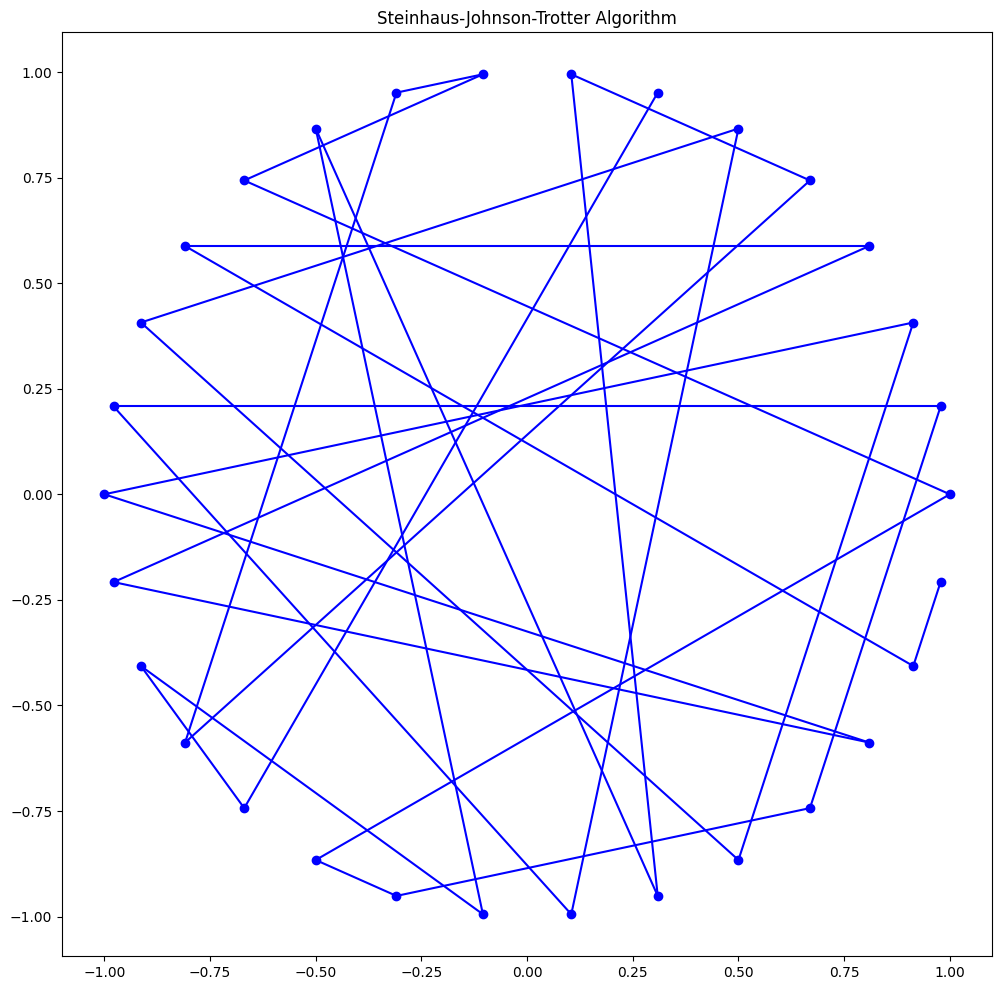

In [21]:
# print_distances(cities, random_solution[0])
plt.figure(figsize=(12, 12))
plt.title("Steinhaus-Johnson-Trotter Algorithm")
[plt.plot([cities[sjt_solution[i] - 1][0], cities[sjt_solution[i + 1] - 1][0]], [cities[sjt_solution[i] - 1][1], cities[sjt_solution[i + 1] - 1][1]], c="b") for i in range(len(cities) - 1)]
plt.scatter(cities[:, 0], cities[:, 1], c="b")
plt.show()

### [Random Search](https://en.wikipedia.org/wiki/Random_search)

Random Search is a simple **[stochastic](https://en.wikipedia.org/wiki/Stochastic)** optimization algorithm that does not use any information about the problem to find the solution. It is a **[Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method)** method that randomly samples the search space to find the solution.

New best solution found: [ 7 13 18 25 12 22  2 28  5  6 19 20 24 23 17 27 16 15  4  1 21  9  3  8
 10  0 14 29 11 26] with fitness 37.72056171528729
New best solution found: [14 25 21  0 27  6  9 18 12  4  7 13 22 17 28  1 24 29 16 20 19 15  3  2
 23  5 11 10 26  8] with fitness 35.28701883478261
New best solution found: [20 25 24 16 26 10 21  5 11 12 15 18  4  9 29 23  7  3  0 19  8  6 28  1
 22 27  2 13 14 17] with fitness 34.61703213019663
New best solution found: [20  6  8 12  4 14 25 22 27  2  5 23 24 29 15 17 28 10 13 16  0 26  3  1
 19 21 18  9 11  7] with fitness 32.321051597459416
New best solution found: [18 22 21 25 26  6  0  1  5  7 13 28 23 17 12 15  3  9 29  2 10 20 24 27
  4 11 19 16 14  8] with fitness 29.810066348049613
New best solution found: [ 4 29  1 18 10 14  3  2  6 13 16 15 23 25 19 27 26  5  9 17 24 22 20 21
  0  8 12  7 11 28] with fitness 29.444212132705733
New best solution found: [14  7 10 15 29 27  3  8 28 22 26 25 23 21 17 18  2  6  0  1  9 12 16 19
  5  

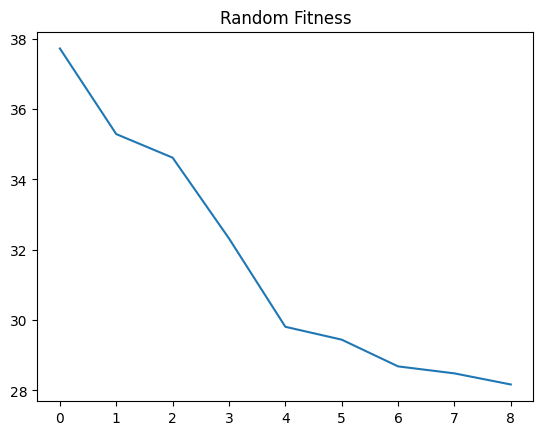

In [11]:
def random_search(cities: np.ndarray, iterations: int = 100) -> tuple[np.ndarray, list[float]]:
    """
    Random Search Algorithm is a simple one. Just generate a random solution and check if it is better than the best solution found so far.
    If it is, then update the best solution. Repeat this process for a given number of iterations.

    ### Parameters:
        cities: np.ndarray - The cities to visit.
        iterations: int - The number of iterations to run the algorithm for.

    ### Returns:
        np.ndarray - The best solution found.
    """
    best_fitness = np.inf
    best_solution = np.arange(CITIES)

    all_fitnesses = []  # list to store all fitnesses
    for _ in range(iterations):  # for each iteration
        solution = np.random.permutation(CITIES)
        fitness = np.sum([get_distance_between_cities(cities[solution[i]], cities[solution[i + 1]]) for i in range(CITIES - 1)])
        if fitness < best_fitness:
            all_fitnesses.append(fitness)  # add fitness to list
            print(f"New best solution found: {solution} with fitness \033[92m{fitness}\033[0m")
            best_fitness = fitness
            best_solution = solution  # update best solution
    return (best_solution, all_fitnesses)  # return best solution

random_solution = random_search(cities, iterations=GENERATIONS*20)  # just run for 10 iterations (for the sake of time)
plot_fitness("Random Fitness", random_solution[1])  # plot the fitnesses

Travelled distance: 28.170350523219184


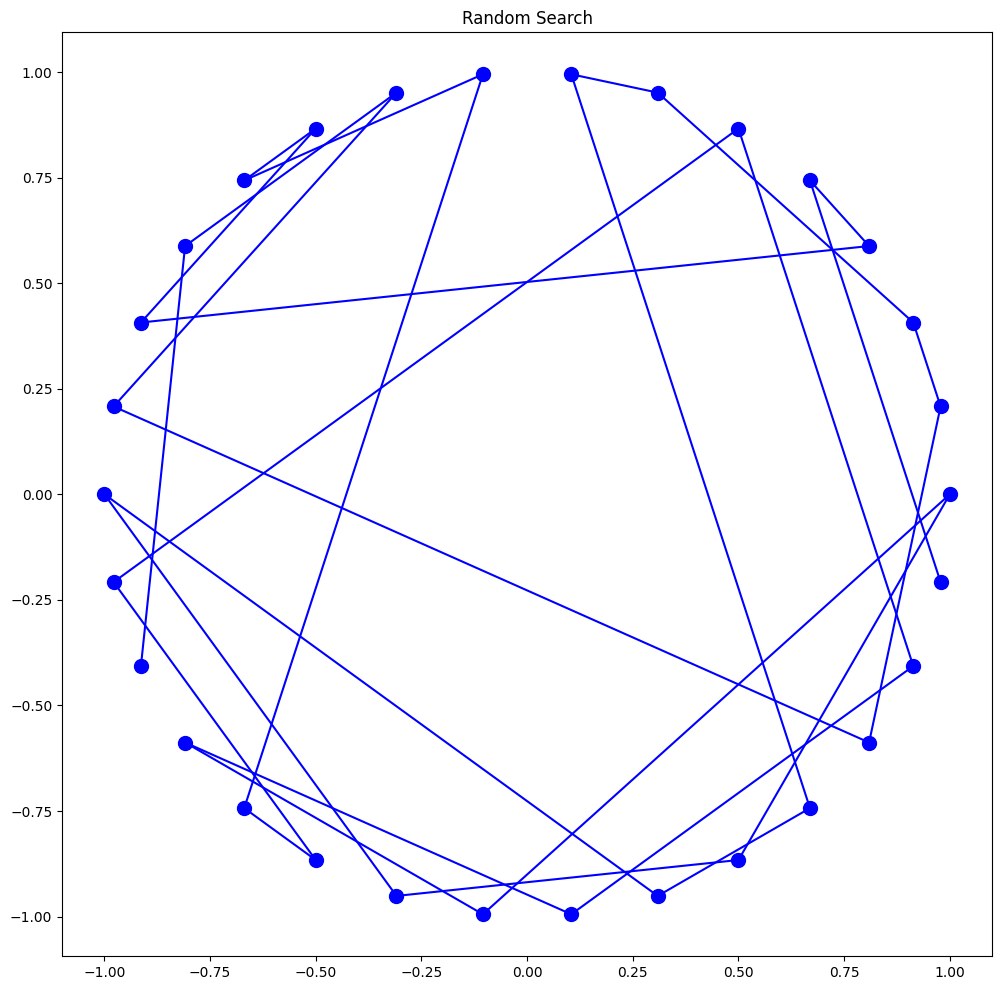

In [12]:
# print_distances(cities, random_solution[0])
print(f"Travelled distance: \033[92m{sum([get_distance_between_cities(cities[random_solution[0][i]], cities[random_solution[0][i + 1]]) for i in range(len(cities) - 1)])}\033[0m")
plot_solution("Random Search", cities, random_solution[0])

### [Hill Climbing Search](https://www.geeksforgeeks.org/introduction-hill-climbing-artificial-intelligence/)

Is a heuristic search used for mathematical optimization problems in the field of Artificial Intelligence.

Given a large set of inputs and a good heuristic function, it tries to find a sufficiently good solution to the problem. This solution may not be the global optimal maximum.

**Steps:**

2. At each iteration, the algorithm selects a pair of edges and checks if swapping them leads to a shorter total distance.
3. If a shorter distance is found, the swap is performed, and the process continues with the modified solution.
4. This process is repeated until no further improvement is possible, and a local optimum is reached.

Initial distance: 35.44410424222225


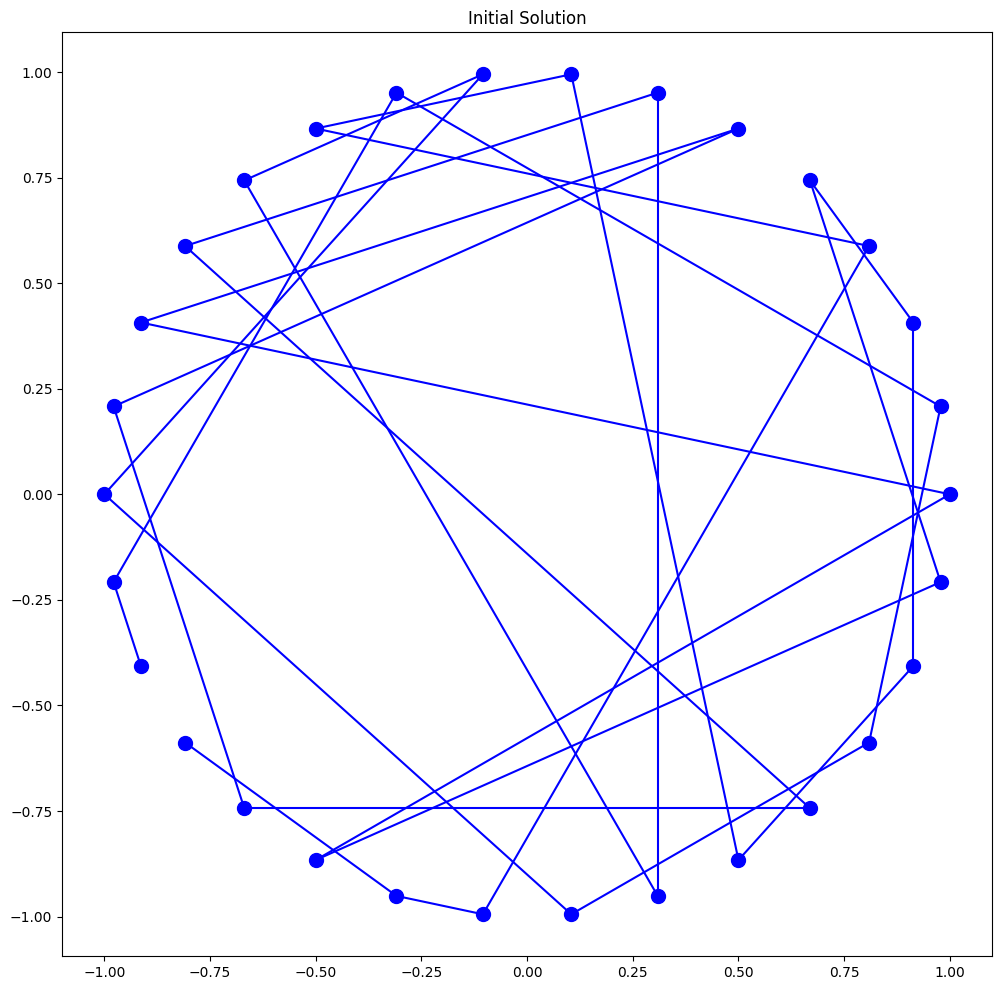

In [13]:
n_cities = 50
# cities = np.array([[np.cos(2 * np.pi * i / n_cities), np.sin(2 * np.pi * i / n_cities)] for i in range(n_cities)])
# city_list = generate_cities(50)  # generate cities

distance_calculation = lambda r, c: np.sum([np.linalg.norm(c[r[i]] - c[r[i - 1]]) for i in range(len(r))])
# where r is the route and c is the city list

swap_algorithm = lambda r, i, k: np.concatenate((r[0:i], r[k:i - 1:-1], r[k + 1:len(r)]))
# where r is the route, i is the first city to swap and k is the second city to swap

solution = np.random.permutation(len(cities))  # generate random solution
print(f"Initial distance: \033[92m{distance_calculation(solution, cities)}\033[0m")  # print initial distance
plot_solution("Initial Solution", cities, solution)

#### Hill Climbing 2 Opt

1. It's performed by **considering pairs of edges** in the current solution.

In [14]:
def hill_climbing_2_opt(solution, city_list):
    """
    Hill Climbing - 2 Opt Algorithm makes small changes to the solution and checks if the new solution is better than the old solution.
    """
    current_best_distance = distance_calculation(solution, city_list)  # calculate the distance
    for swap_1 in range(1, len(solution) - 2):  # for each city except the first and last
        for swap_2 in range(swap_1 + 1, len(solution) - 1):  # for each city except the last
            new_solution = swap_algorithm(solution, swap_1, swap_2)  # swap the cities
            new_distance = distance_calculation(new_solution, city_list)  # calculate the distance
            if new_distance < current_best_distance:  # if the new distance is better than the old distance
                solution = new_solution  # update the solution
                current_best_distance = new_distance  # update the distance
                # print('new best distance: ', current_best_distance)
    return np.array(solution)

Travelled distance: 9.8962637923347


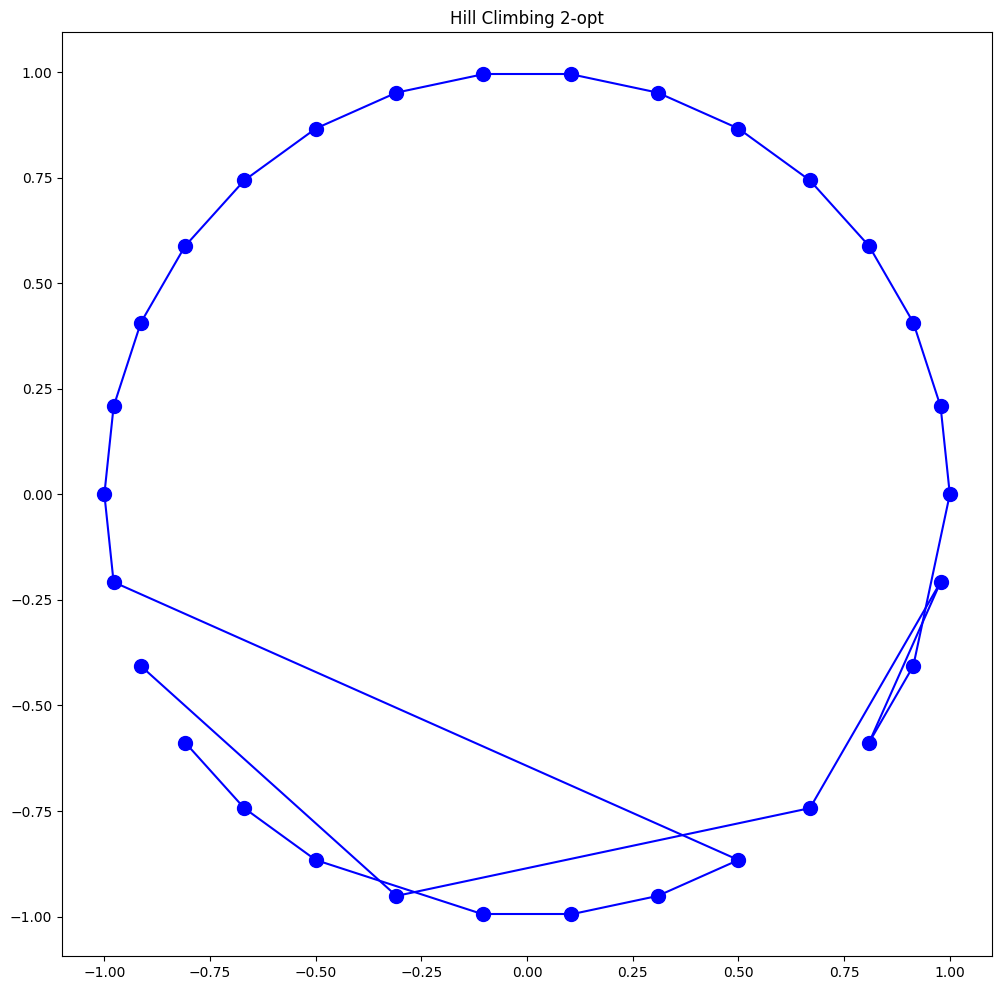

In [15]:
hill_climbing_2_solution = solution.copy()  # copy the solution
hill_climbing_2_solution = hill_climbing_2_opt(hill_climbing_2_solution, cities)  # run the algorithm

# print_distances(city_list, hill_climbing_2_solution)  # print the distances
print(f"Travelled distance: \033[92m{sum([get_distance_between_cities(cities[hill_climbing_2_solution[i]], cities[hill_climbing_2_solution[i + 1]]) for i in range(len(cities) - 1)])}\033[0m")  # print the distance
plot_solution("Hill Climbing 2-opt", cities, hill_climbing_2_solution)  # plot the solution

#### Hill Climbing 3 Opt

1. The Opt3 algorithm expands on the Opt2 algorithm by considering triplets of edges in the current solution.

In [16]:
def hill_climbing_3_opt(solution, city_list):
    """
    Hill Climbing - 3 Opt Algorithm makes small changes to the solution and checks if the new solution is better than the old solution.
    """
    current_best_distance = distance_calculation(solution, city_list)
    for swap_1 in range(1, len(solution) - 3):
        for swap_2 in range(swap_1 + 1, len(solution) - 2):
            for swap_3 in range(swap_2 + 1, len(solution) - 1):
                new_solution = swap_algorithm(solution, swap_1, swap_3)
                new_distance = distance_calculation(new_solution, city_list)
                if new_distance < current_best_distance:
                    solution = new_solution
                    current_best_distance = new_distance
                    # print('new best distance: ', current_best_distance)
    return np.array(solution)

Travelled distance: 6.476183779724328


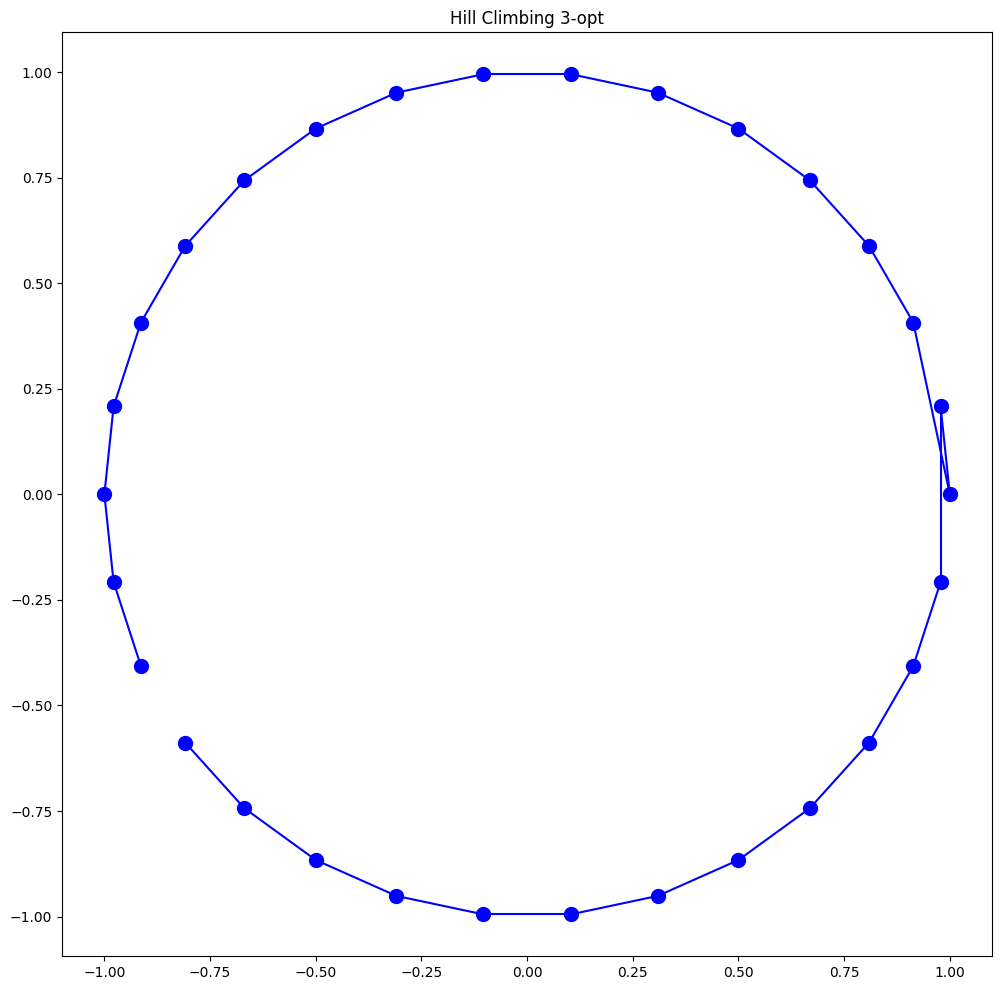

In [17]:
hill_climbing_3_solution = solution.copy()  # copy the solution
hill_climbing_3_solution = hill_climbing_3_opt(hill_climbing_3_solution, cities)  # run the algorithm

# print_distances(city_list, hill_climbing_3_solution)  # print the distances
print(f"Travelled distance: \033[92m{sum([get_distance_between_cities(cities[hill_climbing_3_solution[i]], cities[hill_climbing_3_solution[i + 1]]) for i in range(len(cities) - 1)])}\033[0m")  # print the distance
plot_solution("Hill Climbing 3-opt", cities, hill_climbing_3_solution)  # plot the solution